In [1]:
import gym
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('BipedalWalker-v2')
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.0001
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)

max_steps:  1600
device:  cuda:0
state dim:  24
action dim:  Box(4,)
leraning rate:  0.0001


In [2]:
def save(agent, directory, filename, suffix):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 10001

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        if i_episode % 20 == 0 and i_episode > 0:
            save(agent, 'dir_chk_lr0001', 'weights', str(i_episode))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > 300.5):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

scores, avg_scores = sac_train(max_steps=max_steps)

Ep.: 0, Total Steps: 58, Ep.Steps: 58, Score: -116.42, Avg.Score: -116.42, Time: 00:00:00
Ep.: 1, Total Steps: 133, Ep.Steps: 75, Score: -100.36, Avg.Score: -108.39, Time: 00:00:00
Ep.: 2, Total Steps: 190, Ep.Steps: 57, Score: -113.98, Avg.Score: -110.25, Time: 00:00:00
Ep.: 3, Total Steps: 1790, Ep.Steps: 1600, Score: -86.24, Avg.Score: -104.25, Time: 00:01:23
Ep.: 4, Total Steps: 1884, Ep.Steps: 94, Score: -119.78, Avg.Score: -107.35, Time: 00:01:29
Ep.: 5, Total Steps: 1981, Ep.Steps: 97, Score: -99.84, Avg.Score: -106.10, Time: 00:01:34
Ep.: 6, Total Steps: 3581, Ep.Steps: 1600, Score: -78.23, Avg.Score: -102.12, Time: 00:03:01
Ep.: 7, Total Steps: 3679, Ep.Steps: 98, Score: -107.01, Avg.Score: -102.73, Time: 00:03:06
Ep.: 8, Total Steps: 3761, Ep.Steps: 82, Score: -101.43, Avg.Score: -102.59, Time: 00:03:11
Ep.: 9, Total Steps: 3879, Ep.Steps: 118, Score: -101.66, Avg.Score: -102.49, Time: 00:03:17
Ep.: 10, Total Steps: 3919, Ep.Steps: 40, Score: -112.11, Avg.Score: -103.37, Time

Ep.: 87, Total Steps: 52674, Ep.Steps: 1600, Score: -61.00, Avg.Score: -106.53, Time: 00:50:16
Ep.: 88, Total Steps: 54274, Ep.Steps: 1600, Score: -72.29, Avg.Score: -106.14, Time: 00:51:49
Ep.: 89, Total Steps: 55874, Ep.Steps: 1600, Score: -82.94, Avg.Score: -105.88, Time: 00:53:22
Ep.: 90, Total Steps: 57474, Ep.Steps: 1600, Score: -76.12, Avg.Score: -105.56, Time: 00:54:55
Ep.: 91, Total Steps: 59074, Ep.Steps: 1600, Score: -82.73, Avg.Score: -105.31, Time: 00:56:28
Ep.: 92, Total Steps: 60674, Ep.Steps: 1600, Score: -110.70, Avg.Score: -105.37, Time: 00:58:01
Ep.: 93, Total Steps: 62274, Ep.Steps: 1600, Score: -70.85, Avg.Score: -105.00, Time: 00:59:34
Ep.: 94, Total Steps: 63874, Ep.Steps: 1600, Score: -78.17, Avg.Score: -104.72, Time: 01:01:07
Ep.: 95, Total Steps: 63947, Ep.Steps: 73, Score: -121.28, Avg.Score: -104.89, Time: 01:01:11
Ep.: 96, Total Steps: 65547, Ep.Steps: 1600, Score: -81.22, Avg.Score: -104.64, Time: 01:02:44
Ep.: 97, Total Steps: 67147, Ep.Steps: 1600, Score

Ep.: 173, Total Steps: 178222, Ep.Steps: 1600, Score: -27.92, Avg.Score: -68.61, Time: 02:55:10
Ep.: 174, Total Steps: 179822, Ep.Steps: 1600, Score: -13.59, Avg.Score: -67.97, Time: 02:56:44
Ep.: 175, Total Steps: 181422, Ep.Steps: 1600, Score: -31.38, Avg.Score: -67.36, Time: 02:58:18
Ep.: 176, Total Steps: 183022, Ep.Steps: 1600, Score: -23.95, Avg.Score: -66.63, Time: 02:59:52
Ep.: 177, Total Steps: 184622, Ep.Steps: 1600, Score: -27.48, Avg.Score: -65.92, Time: 03:01:27
Ep.: 178, Total Steps: 186222, Ep.Steps: 1600, Score: -39.70, Avg.Score: -65.45, Time: 03:03:01
Ep.: 179, Total Steps: 187822, Ep.Steps: 1600, Score: -35.42, Avg.Score: -65.04, Time: 03:04:36
Ep.: 180, Total Steps: 189422, Ep.Steps: 1600, Score: -29.06, Avg.Score: -63.82, Time: 03:06:10
Ep.: 181, Total Steps: 191022, Ep.Steps: 1600, Score: -34.21, Avg.Score: -62.87, Time: 03:07:44
Ep.: 182, Total Steps: 192622, Ep.Steps: 1600, Score: -23.99, Avg.Score: -61.96, Time: 03:09:18
Ep.: 183, Total Steps: 194222, Ep.Steps:

Ep.: 260, Total Steps: 294848, Ep.Steps: 1600, Score: 62.66, Avg.Score: -15.16, Time: 04:50:38
Ep.: 261, Total Steps: 296448, Ep.Steps: 1600, Score: 17.92, Avg.Score: -14.76, Time: 04:52:11
Ep.: 262, Total Steps: 296547, Ep.Steps: 99, Score: -127.31, Avg.Score: -15.64, Time: 04:52:17
Ep.: 263, Total Steps: 298147, Ep.Steps: 1600, Score: 55.96, Avg.Score: -14.36, Time: 04:53:50
Ep.: 264, Total Steps: 298198, Ep.Steps: 51, Score: -117.85, Avg.Score: -15.05, Time: 04:53:52
Ep.: 265, Total Steps: 298251, Ep.Steps: 53, Score: -116.55, Avg.Score: -15.18, Time: 04:53:56
Ep.: 266, Total Steps: 298299, Ep.Steps: 48, Score: -112.15, Avg.Score: -15.87, Time: 04:53:58
Ep.: 267, Total Steps: 298363, Ep.Steps: 64, Score: -116.55, Avg.Score: -16.72, Time: 04:54:02
Ep.: 268, Total Steps: 298408, Ep.Steps: 45, Score: -111.85, Avg.Score: -17.43, Time: 04:54:05
Ep.: 269, Total Steps: 298468, Ep.Steps: 60, Score: -120.20, Avg.Score: -18.08, Time: 04:54:08
Ep.: 270, Total Steps: 298561, Ep.Steps: 93, Score

Ep.: 347, Total Steps: 394442, Ep.Steps: 611, Score: -38.32, Avg.Score: 63.50, Time: 06:28:22
Ep.: 348, Total Steps: 396042, Ep.Steps: 1600, Score: 239.59, Avg.Score: 65.26, Time: 06:30:04
Ep.: 349, Total Steps: 396113, Ep.Steps: 71, Score: -119.11, Avg.Score: 63.61, Time: 06:30:09
Ep.: 350, Total Steps: 397066, Ep.Steps: 953, Score: -19.19, Avg.Score: 64.37, Time: 06:31:05
Ep.: 351, Total Steps: 398666, Ep.Steps: 1600, Score: 226.97, Avg.Score: 66.13, Time: 06:32:38
Ep.: 352, Total Steps: 400266, Ep.Steps: 1600, Score: 211.34, Avg.Score: 69.24, Time: 06:34:11
Ep.: 353, Total Steps: 401748, Ep.Steps: 1482, Score: 118.34, Avg.Score: 69.85, Time: 06:35:38
Ep.: 354, Total Steps: 403327, Ep.Steps: 1579, Score: 252.88, Avg.Score: 71.72, Time: 06:37:09
Ep.: 355, Total Steps: 404824, Ep.Steps: 1497, Score: 259.85, Avg.Score: 75.04, Time: 06:38:36
Ep.: 356, Total Steps: 406336, Ep.Steps: 1512, Score: 254.81, Avg.Score: 78.40, Time: 06:40:04
Ep.: 357, Total Steps: 407780, Ep.Steps: 1444, Score:

Ep.: 433, Total Steps: 506737, Ep.Steps: 1109, Score: 284.92, Avg.Score: 229.95, Time: 08:16:59
Ep.: 434, Total Steps: 507884, Ep.Steps: 1147, Score: 281.95, Avg.Score: 233.14, Time: 08:18:05
Ep.: 435, Total Steps: 509013, Ep.Steps: 1129, Score: 281.95, Avg.Score: 236.58, Time: 08:19:10
Ep.: 436, Total Steps: 510127, Ep.Steps: 1114, Score: 282.76, Avg.Score: 239.31, Time: 08:20:15
Ep.: 437, Total Steps: 511248, Ep.Steps: 1121, Score: 283.72, Avg.Score: 242.39, Time: 08:21:20
Ep.: 438, Total Steps: 512308, Ep.Steps: 1060, Score: 287.44, Avg.Score: 245.73, Time: 08:22:21
Ep.: 439, Total Steps: 513357, Ep.Steps: 1049, Score: 286.72, Avg.Score: 247.42, Time: 08:23:22
Ep.: 440, Total Steps: 514438, Ep.Steps: 1081, Score: 284.44, Avg.Score: 247.64, Time: 08:24:25
Ep.: 441, Total Steps: 515510, Ep.Steps: 1072, Score: 285.61, Avg.Score: 247.89, Time: 08:25:27
Ep.: 442, Total Steps: 516570, Ep.Steps: 1060, Score: 286.54, Avg.Score: 251.39, Time: 08:26:28
Ep.: 443, Total Steps: 517621, Ep.Steps:

Ep.: 519, Total Steps: 592877, Ep.Steps: 923, Score: 297.95, Avg.Score: 287.86, Time: 09:40:12
Ep.: 520, Total Steps: 593407, Ep.Steps: 530, Score: 60.62, Avg.Score: 285.66, Time: 09:40:43
Ep.: 521, Total Steps: 594295, Ep.Steps: 888, Score: 298.59, Avg.Score: 285.90, Time: 09:41:34
Ep.: 522, Total Steps: 595202, Ep.Steps: 907, Score: 296.86, Avg.Score: 286.07, Time: 09:42:27
Ep.: 523, Total Steps: 596115, Ep.Steps: 913, Score: 297.53, Avg.Score: 286.24, Time: 09:43:20
Ep.: 524, Total Steps: 597038, Ep.Steps: 923, Score: 295.96, Avg.Score: 286.36, Time: 09:44:13
Ep.: 525, Total Steps: 597933, Ep.Steps: 895, Score: 293.82, Avg.Score: 286.46, Time: 09:45:05
Ep.: 526, Total Steps: 598828, Ep.Steps: 895, Score: 294.79, Avg.Score: 286.68, Time: 09:45:57
Ep.: 527, Total Steps: 599762, Ep.Steps: 934, Score: 295.75, Avg.Score: 286.81, Time: 09:46:51
Ep.: 528, Total Steps: 600678, Ep.Steps: 916, Score: 294.86, Avg.Score: 286.93, Time: 09:47:44
Ep.: 529, Total Steps: 601612, Ep.Steps: 934, Score

Ep.: 606, Total Steps: 670686, Ep.Steps: 901, Score: 298.26, Avg.Score: 294.32, Time: 10:57:18
Ep.: 607, Total Steps: 671566, Ep.Steps: 880, Score: 296.87, Avg.Score: 294.33, Time: 10:58:10
Ep.: 608, Total Steps: 672451, Ep.Steps: 885, Score: 299.22, Avg.Score: 294.38, Time: 10:59:03
Ep.: 609, Total Steps: 673316, Ep.Steps: 865, Score: 298.95, Avg.Score: 294.41, Time: 10:59:53
Ep.: 610, Total Steps: 674169, Ep.Steps: 853, Score: 297.32, Avg.Score: 294.42, Time: 11:00:46
Ep.: 611, Total Steps: 675028, Ep.Steps: 859, Score: 297.11, Avg.Score: 294.43, Time: 11:01:37
Ep.: 612, Total Steps: 675870, Ep.Steps: 842, Score: 298.94, Avg.Score: 294.45, Time: 11:02:27
Ep.: 613, Total Steps: 676187, Ep.Steps: 317, Score: -18.50, Avg.Score: 291.33, Time: 11:02:46
Ep.: 614, Total Steps: 677033, Ep.Steps: 846, Score: 296.49, Avg.Score: 291.34, Time: 11:03:35
Ep.: 615, Total Steps: 677909, Ep.Steps: 876, Score: 297.99, Avg.Score: 291.40, Time: 11:04:26
Ep.: 616, Total Steps: 678797, Ep.Steps: 888, Scor

Ep.: 693, Total Steps: 744548, Ep.Steps: 888, Score: 302.08, Avg.Score: 294.32, Time: 12:12:31
Ep.: 694, Total Steps: 745409, Ep.Steps: 861, Score: 303.74, Avg.Score: 294.37, Time: 12:13:23
Ep.: 695, Total Steps: 746255, Ep.Steps: 846, Score: 304.20, Avg.Score: 294.43, Time: 12:14:13
Ep.: 696, Total Steps: 747095, Ep.Steps: 840, Score: 305.14, Avg.Score: 294.51, Time: 12:15:04
Ep.: 697, Total Steps: 747903, Ep.Steps: 808, Score: 305.75, Avg.Score: 294.60, Time: 12:15:52
Ep.: 698, Total Steps: 748765, Ep.Steps: 862, Score: 301.62, Avg.Score: 294.61, Time: 12:16:44
Ep.: 699, Total Steps: 749626, Ep.Steps: 861, Score: 302.43, Avg.Score: 294.67, Time: 12:17:36
Ep.: 700, Total Steps: 750487, Ep.Steps: 861, Score: 303.67, Avg.Score: 294.72, Time: 12:18:27
Ep.: 701, Total Steps: 751349, Ep.Steps: 862, Score: 304.16, Avg.Score: 294.78, Time: 12:19:19
Ep.: 702, Total Steps: 752207, Ep.Steps: 858, Score: 302.79, Avg.Score: 294.82, Time: 12:20:11
Ep.: 703, Total Steps: 753044, Ep.Steps: 837, Scor

In [4]:
save(agent, 'dir_chk_lr0001', 'weights', 'final')

length of scores:  756 , len of avg_scores:  756


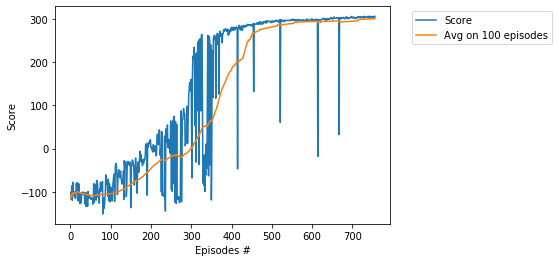

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [7]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 304.85,	Score: 304.85 	Time: 00:00:18
Episode 1	Average Score: 304.79,	Score: 304.72 	Time: 00:00:14
Episode 2	Average Score: 304.52,	Score: 304.00 	Time: 00:00:13
Episode 3	Average Score: 304.49,	Score: 304.39 	Time: 00:00:14
Episode 4	Average Score: 304.79,	Score: 305.97 	Time: 00:00:14
Episode 5	Average Score: 304.74,	Score: 304.49 	Time: 00:00:13


In [8]:
env.close()